In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from scipy.stats import zscore
import torch

Data Preprocessing

In [2]:
#data preprocessing
df = pd.read_csv("data-performance.csv")
# no missing values
df.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

In [3]:
n_df = df.drop(columns=['gender','class'])
z_scores = zscore(n_df)
threshold = 3

outliers_zscore = (abs(z_scores) > threshold)
outliers_zscore_rows = n_df[outliers_zscore.any(axis=1)]
total_outliers_zscore = outliers_zscore_rows.sum()
print(f"Total number of rows with outliers: {total_outliers_zscore}")
print("Outliers detected using Z-score:")
print(outliers_zscore_rows)
df_cleaned = df[~outliers_zscore.any(axis=1)]
print(f"Shape of the cleaned DataFrame: {df_cleaned.shape}")

df_cleaned.head()

Total number of rows with outliers: age                         9564.00
height_cm                  40438.00
weight_kg                  18776.66
body fat_%                  7422.88
diastolic                  19035.40
systolic                   31757.90
gripForce                   8001.40
sit and bend forward_cm      664.60
sit-ups counts              6460.60
broad jump_cm              36774.00
dtype: float64
Outliers detected using Z-score:
       age  height_cm  weight_kg  body fat_%  diastolic  systolic  gripForce  \
57    33.0      166.7       66.9        25.1       94.0     126.0       39.2   
90    48.0      160.0      109.2        50.6       94.0     141.0       36.9   
108   34.0      160.0       90.7        50.2       70.0     122.0       26.1   
129   34.0      173.0      106.4        42.4       91.0     131.0       28.2   
223   47.0      166.2       52.9        10.6       70.0     108.0       35.6   
...    ...        ...        ...         ...        ...       ...        ...

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,61.0,F,150.2,47.5,23.6,75.0,132.0,25.6,22.0,23.0,130.0,A
1,56.0,F,157.6,58.1,32.0,75.0,156.0,24.9,17.0,22.0,132.0,B
2,40.0,F,165.4,64.2,30.0,77.0,138.0,24.0,19.8,32.0,167.0,D
3,59.0,F,164.0,58.7,29.5,80.0,158.0,25.2,21.2,23.0,135.0,B
4,45.0,M,176.7,82.6,20.6,80.0,134.0,38.0,-2.7,35.0,172.0,D


In [4]:
df_cleaned['gender'] = df_cleaned['gender'].map({'F': 0, 'M': 1}) # convert gender to number
# add additional features
df_cleaned['BMI'] = df_cleaned['weight_kg'] / ((df_cleaned['height_cm']/100)** 2)  # convert height to meters, and calculate BMI
df_cleaned['BP_ratio'] = df_cleaned['diastolic'] / df_cleaned['systolic'] # calculate Blood Pressure ratio
df_cleaned.head(10)

C:\Users\MAKANI\AppData\Local\Temp\ipykernel_24336\2364295045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['gender'] = df_cleaned['gender'].map({'F': 0, 'M': 1}) # convert gender to number
C:\Users\MAKANI\AppData\Local\Temp\ipykernel_24336\2364295045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['BMI'] = df_cleaned['weight_kg'] / ((df_cleaned['height_cm']/100)** 2)  # convert height to meters, and calculate BMI
C:\Users\MAKANI\AppData\Local\Temp\ipykernel_24336\2364295045.

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,BMI,BP_ratio
0,61.0,0,150.2,47.5,23.6,75.0,132.0,25.6,22.0,23.0,130.0,A,21.054927,0.568182
1,56.0,0,157.6,58.1,32.0,75.0,156.0,24.9,17.0,22.0,132.0,B,23.391803,0.480769
2,40.0,0,165.4,64.2,30.0,77.0,138.0,24.0,19.8,32.0,167.0,D,23.467348,0.557971
3,59.0,0,164.0,58.7,29.5,80.0,158.0,25.2,21.2,23.0,135.0,B,21.824807,0.506329
4,45.0,1,176.7,82.6,20.6,80.0,134.0,38.0,-2.7,35.0,172.0,D,26.454950,0.597015
5,22.0,0,165.8,55.4,28.8,89.0,114.0,21.8,8.7,31.0,152.0,D,20.153047,0.780702
6,29.0,0,161.1,55.9,32.8,60.0,137.0,25.0,16.0,3.0,122.0,D,21.538761,0.437956
7,25.0,1,175.1,71.0,15.8,98.0,158.0,53.1,7.5,49.0,227.0,C,23.157201,0.620253
8,29.0,1,177.9,65.2,10.6,95.0,148.0,44.5,18.6,53.0,239.0,B,20.601351,0.641892
9,41.0,1,178.9,69.2,16.4,74.0,115.0,36.0,19.1,36.0,223.0,C,21.621480,0.643478


In [5]:
df_cleaned.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,BMI,BP_ratio
count,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000
mean,36.996824,0.648770,168.797859,68.009697,23.725991,79.024314,130.371414,36.637249,13.909132,38.074939,187.978279,23.741765,0.607538
std,13.672246,0.477379,8.456955,11.802894,7.157973,10.529275,14.487150,10.452076,7.869424,14.268412,39.155248,2.902568,0.061363
min,21.000000,0.000000,143.400000,31.900000,3.500000,47.000000,88.000000,5.300000,-12.000000,0.000000,68.000000,11.904011,0.315789
25%,25.000000,0.000000,162.700000,59.000000,18.600000,72.000000,120.000000,27.200000,9.300000,29.000000,160.000000,21.759139,0.567568
50%,33.000000,1.000000,169.600000,68.100000,23.300000,79.000000,130.000000,37.800000,14.700000,40.000000,192.000000,23.640673,0.608696
75%,48.000000,1.000000,175.000000,76.000000,28.600000,87.000000,141.000000,44.525000,19.400000,49.000000,219.000000,25.529683,0.649573
max,64.000000,1.000000,193.800000,104.700000,45.700000,111.000000,171.000000,67.600000,35.200000,80.000000,303.000000,35.777973,1.042105


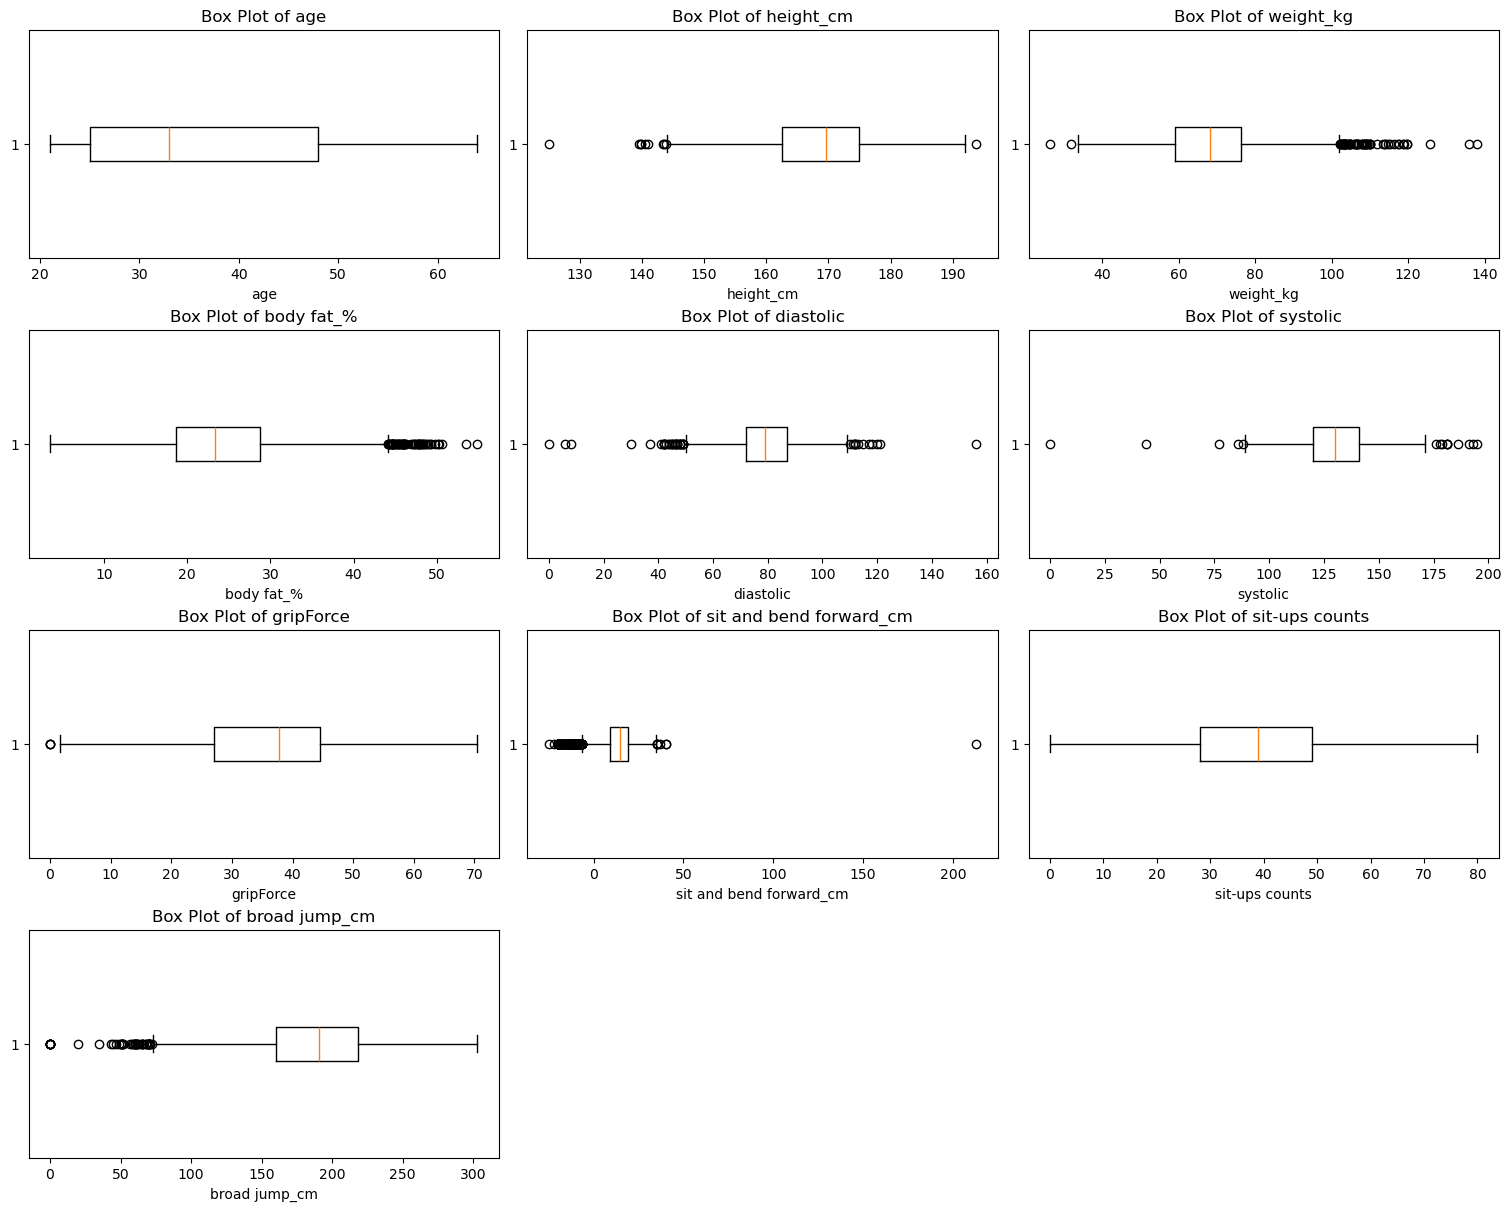

In [6]:
# Select numerical features excluding 'gender'
features = df.select_dtypes(include=['number']).columns
features = [feature for feature in features if feature.lower() != 'gender']

num_features = len(features)

# Determine the number of rows and columns for subplots
rows = (num_features // 3) + (num_features % 3 > 0) 
cols = min(3, num_features)  

# Create a figure for subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten() 

# Generate box plots for each feature
for i, feature in enumerate(features):
    axes[i].boxplot(df[feature], vert=False)
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("box_plots_of_features.pdf", format='pdf')
plt.show()



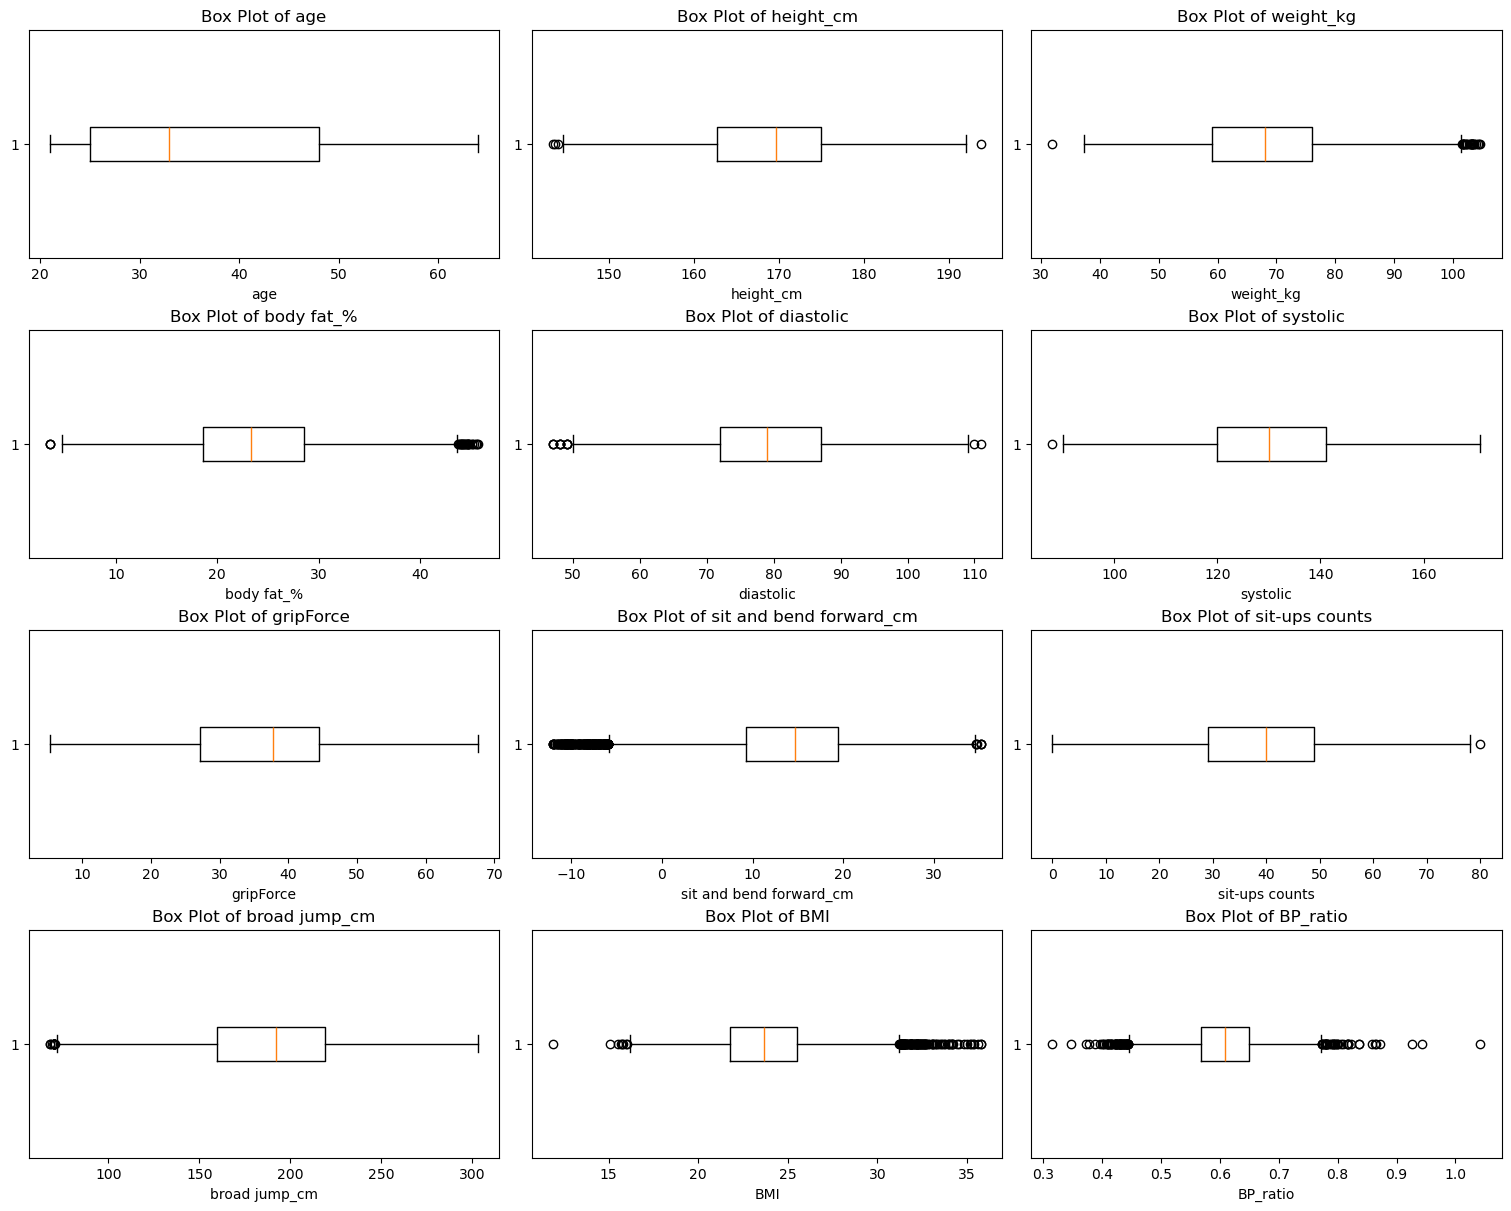

In [7]:
# Select numerical features excluding 'gender'
features = df_cleaned.select_dtypes(include=['number']).columns
features = [feature for feature in features if feature.lower() != 'gender']

num_features = len(features)


rows = (num_features // 3) + (num_features % 3 > 0)  
cols = min(3, num_features)  

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)
axes = axes.flatten()  

# Generate box plots for each feature
for i, feature in enumerate(features):
    axes[i].boxplot(df_cleaned[feature], vert=False)
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("box_plots_of_features_new.pdf", format='pdf')
plt.show()


class
D    3099
C    2976
B    2672
A    1013
Name: count, dtype: int64


<Axes: xlabel='class', ylabel='count'>

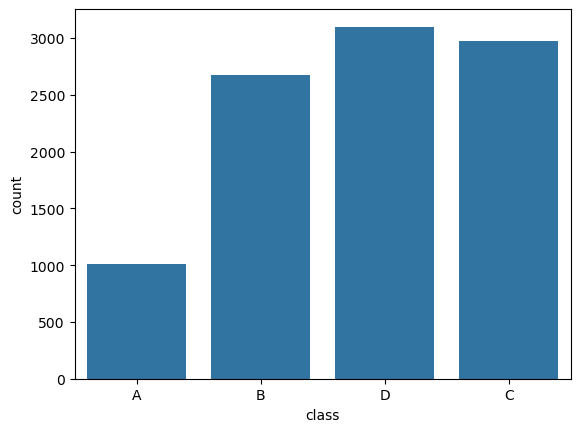

In [8]:
print(df_cleaned['class'].value_counts())
sb.countplot(x='class', data=df_cleaned)

Use cleand data as dataframe

In [9]:
df = df_cleaned
df.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,BMI,BP_ratio
count,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000,9760.000000
mean,36.996824,0.648770,168.797859,68.009697,23.725991,79.024314,130.371414,36.637249,13.909132,38.074939,187.978279,23.741765,0.607538
std,13.672246,0.477379,8.456955,11.802894,7.157973,10.529275,14.487150,10.452076,7.869424,14.268412,39.155248,2.902568,0.061363
min,21.000000,0.000000,143.400000,31.900000,3.500000,47.000000,88.000000,5.300000,-12.000000,0.000000,68.000000,11.904011,0.315789
25%,25.000000,0.000000,162.700000,59.000000,18.600000,72.000000,120.000000,27.200000,9.300000,29.000000,160.000000,21.759139,0.567568
50%,33.000000,1.000000,169.600000,68.100000,23.300000,79.000000,130.000000,37.800000,14.700000,40.000000,192.000000,23.640673,0.608696
75%,48.000000,1.000000,175.000000,76.000000,28.600000,87.000000,141.000000,44.525000,19.400000,49.000000,219.000000,25.529683,0.649573
max,64.000000,1.000000,193.800000,104.700000,45.700000,111.000000,171.000000,67.600000,35.200000,80.000000,303.000000,35.777973,1.042105


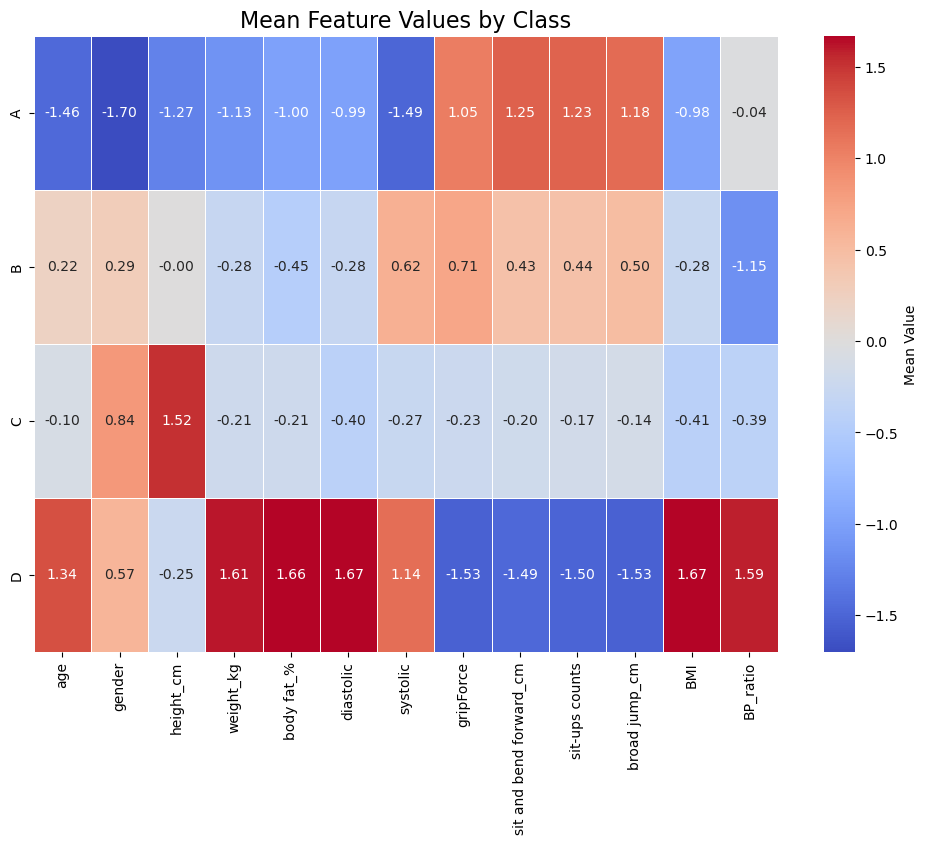

<Figure size 640x480 with 0 Axes>

In [10]:
df_grouped = df.groupby('class').mean()

scaler = StandardScaler()
df_grouped_scaled = scaler.fit_transform(df_grouped)

plt.figure(figsize=(12, 8)) 
sb.heatmap(df_grouped_scaled, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, 
           cbar_kws={'label': 'Mean Value'}, 
           xticklabels=df_grouped.columns, 
           yticklabels=['A', 'B', 'C', 'D'])

plt.title('Mean Feature Values by Class', fontsize=16)
plt.show()

plt.savefig("mean_feature_values_by_class.pdf", format='pdf')

C:\Users\MAKANI\AppData\Local\Temp\ipykernel_24336\82410806.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='class', data=df, palette='Purples')


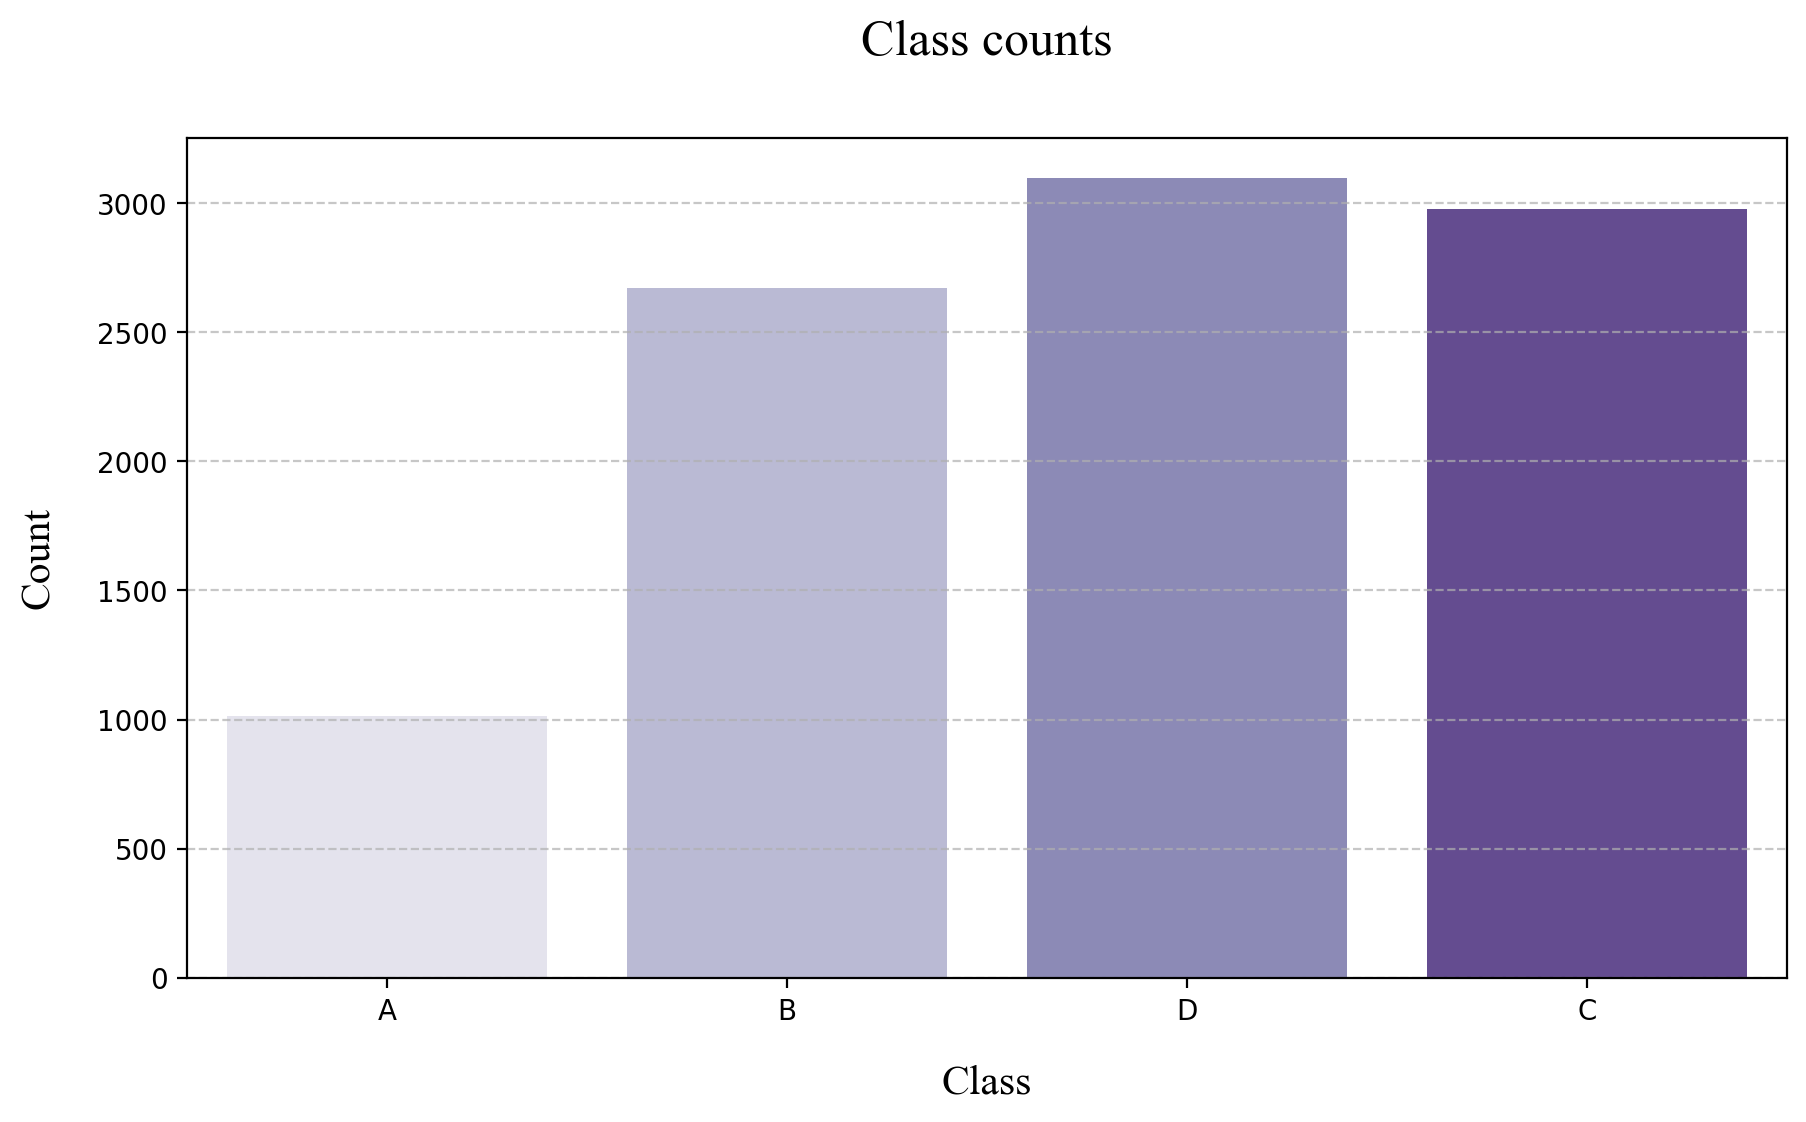

In [11]:
plt.figure(figsize=(10, 6), dpi=200)
sb.countplot(x='class', data=df, palette='Purples')
plt.title('Class counts', fontsize=18, fontweight='light', pad=30, fontname='Times New Roman')
plt.xlabel('Class', fontsize=15, fontweight='light', labelpad=14, fontname='Times New Roman')
plt.ylabel('Count', fontsize=15, fontweight='light', labelpad=14, fontname='Times New Roman')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.9) 
plt.savefig("class_counts_plot.pdf", format='pdf')
plt.show()

Classifer model - Logistic Regression

In [12]:
# data
df = pd.read_csv("cleaned_data.csv")
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_logreg = {
    'penalty': ['l1','l2'],
    'C': [0.1],}

grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=2000, random_state=15, solver='saga'), param_grid_logreg, cv=5, return_train_score=True, scoring="f1_micro")
grid_search_logreg.fit(X_train_scaled,y_train)

print(grid_search_logreg.best_estimator_.get_params())

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 15, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [13]:
logreg_model = grid_search_logreg.best_estimator_.fit(X_train_scaled, y_train)
print("Test set score: {:.4f}".format(logreg_model.score(X_test_scaled, y_test)))
pred_logreg = logreg_model.predict(X_test_scaled)
confusion_logreg = confusion_matrix(y_test, pred_logreg)

Test set score: 0.6016


Classifier - svm

In [14]:
df = pd.read_csv("cleaned_data.csv")
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_svm = {
    'C': [0.1, 1, 10]
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, return_train_score=True, scoring="f1_micro",n_jobs=-1)
grid_search_svm.fit(X_train_scaled,y_train)

print(grid_search_svm.best_estimator_.get_params())

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [15]:
svm_model = grid_search_svm.best_estimator_.fit(X_train_scaled, y_train)
print("Test set score: {:.4f}".format(svm_model.score(X_test_scaled, y_test)))
pred_svm = svm_model.predict(X_test_scaled)
confusion_svm = confusion_matrix(y_test, pred_svm)

Test set score: 0.6939


Classifier - Random Forest

In [16]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

param_grid_ranfor = {
    'n_estimators': [900, 1200, 1500],
    'max_depth': [20, 30],
}
grid_search_ranfor = GridSearchCV(RandomForestClassifier(), param_grid_ranfor, cv=5, return_train_score=True, scoring="f1_micro")
grid_search_ranfor.fit(X_train,y_train)

print(grid_search_ranfor.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 1500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [17]:
ranfor_model = grid_search_ranfor.best_estimator_.fit(X_train, y_train)
print("Test set score: {:.4f}".format(ranfor_model.score(X_test, y_test)))
pred_ranfor = ranfor_model.predict(X_test)
confusion_ranfor = confusion_matrix(y_test, pred_ranfor)

Test set score: 0.7279


Classifier - Gradient Boost

In [18]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

param_grid_grad = {
    'learning_rate': [0.1, 0.2], 
    'n_estimators': [100, 200, 300],    
    'max_depth': [5],                      
}

grid_search_grad = GridSearchCV(GradientBoostingClassifier(), param_grid_grad, cv=5, return_train_score=True, scoring="f1_micro")
grid_search_grad.fit(X_train,y_train)

print(grid_search_grad.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [19]:
grad_model = grid_search_grad.best_estimator_.fit(X_train, y_train)
print("Test set score: {:.4f}".format(grad_model.score(X_test, y_test)))
pred_grad = grad_model.predict(X_test)
confusion_grad = confusion_matrix(y_test, pred_grad)

Test set score: 0.7242


Classifier - MLP

In [20]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(50,), (120,), (50, 50)],
    'alpha': [0.001, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
    'batch_size': [64]
}

grid_search_mlp = GridSearchCV(MLPClassifier(), param_grid, cv=5, return_train_score=True, scoring="f1_micro")
grid_search_mlp.fit(X_train_scaled,y_train)

print(grid_search_mlp.best_estimator_.get_params())

c:\Users\MAKANI\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MAKANI\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MAKANI\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MAKANI\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MAKANI\anaconda3\Lib\site-packages\sklearn\neural_network\_

{'activation': 'relu', 'alpha': 0.1, 'batch_size': 64, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [21]:
mlp_model = grid_search_mlp.best_estimator_.fit(X_train_scaled, y_train)
print("Test set score: {:.4f}".format(mlp_model.score(X_test_scaled, y_test)))
pred_mlp = mlp_model.predict(X_test_scaled)
confusion_mlp = confusion_matrix(y_test, pred_mlp)

Test set score: 0.7279


Confusion Matrix Plot combined

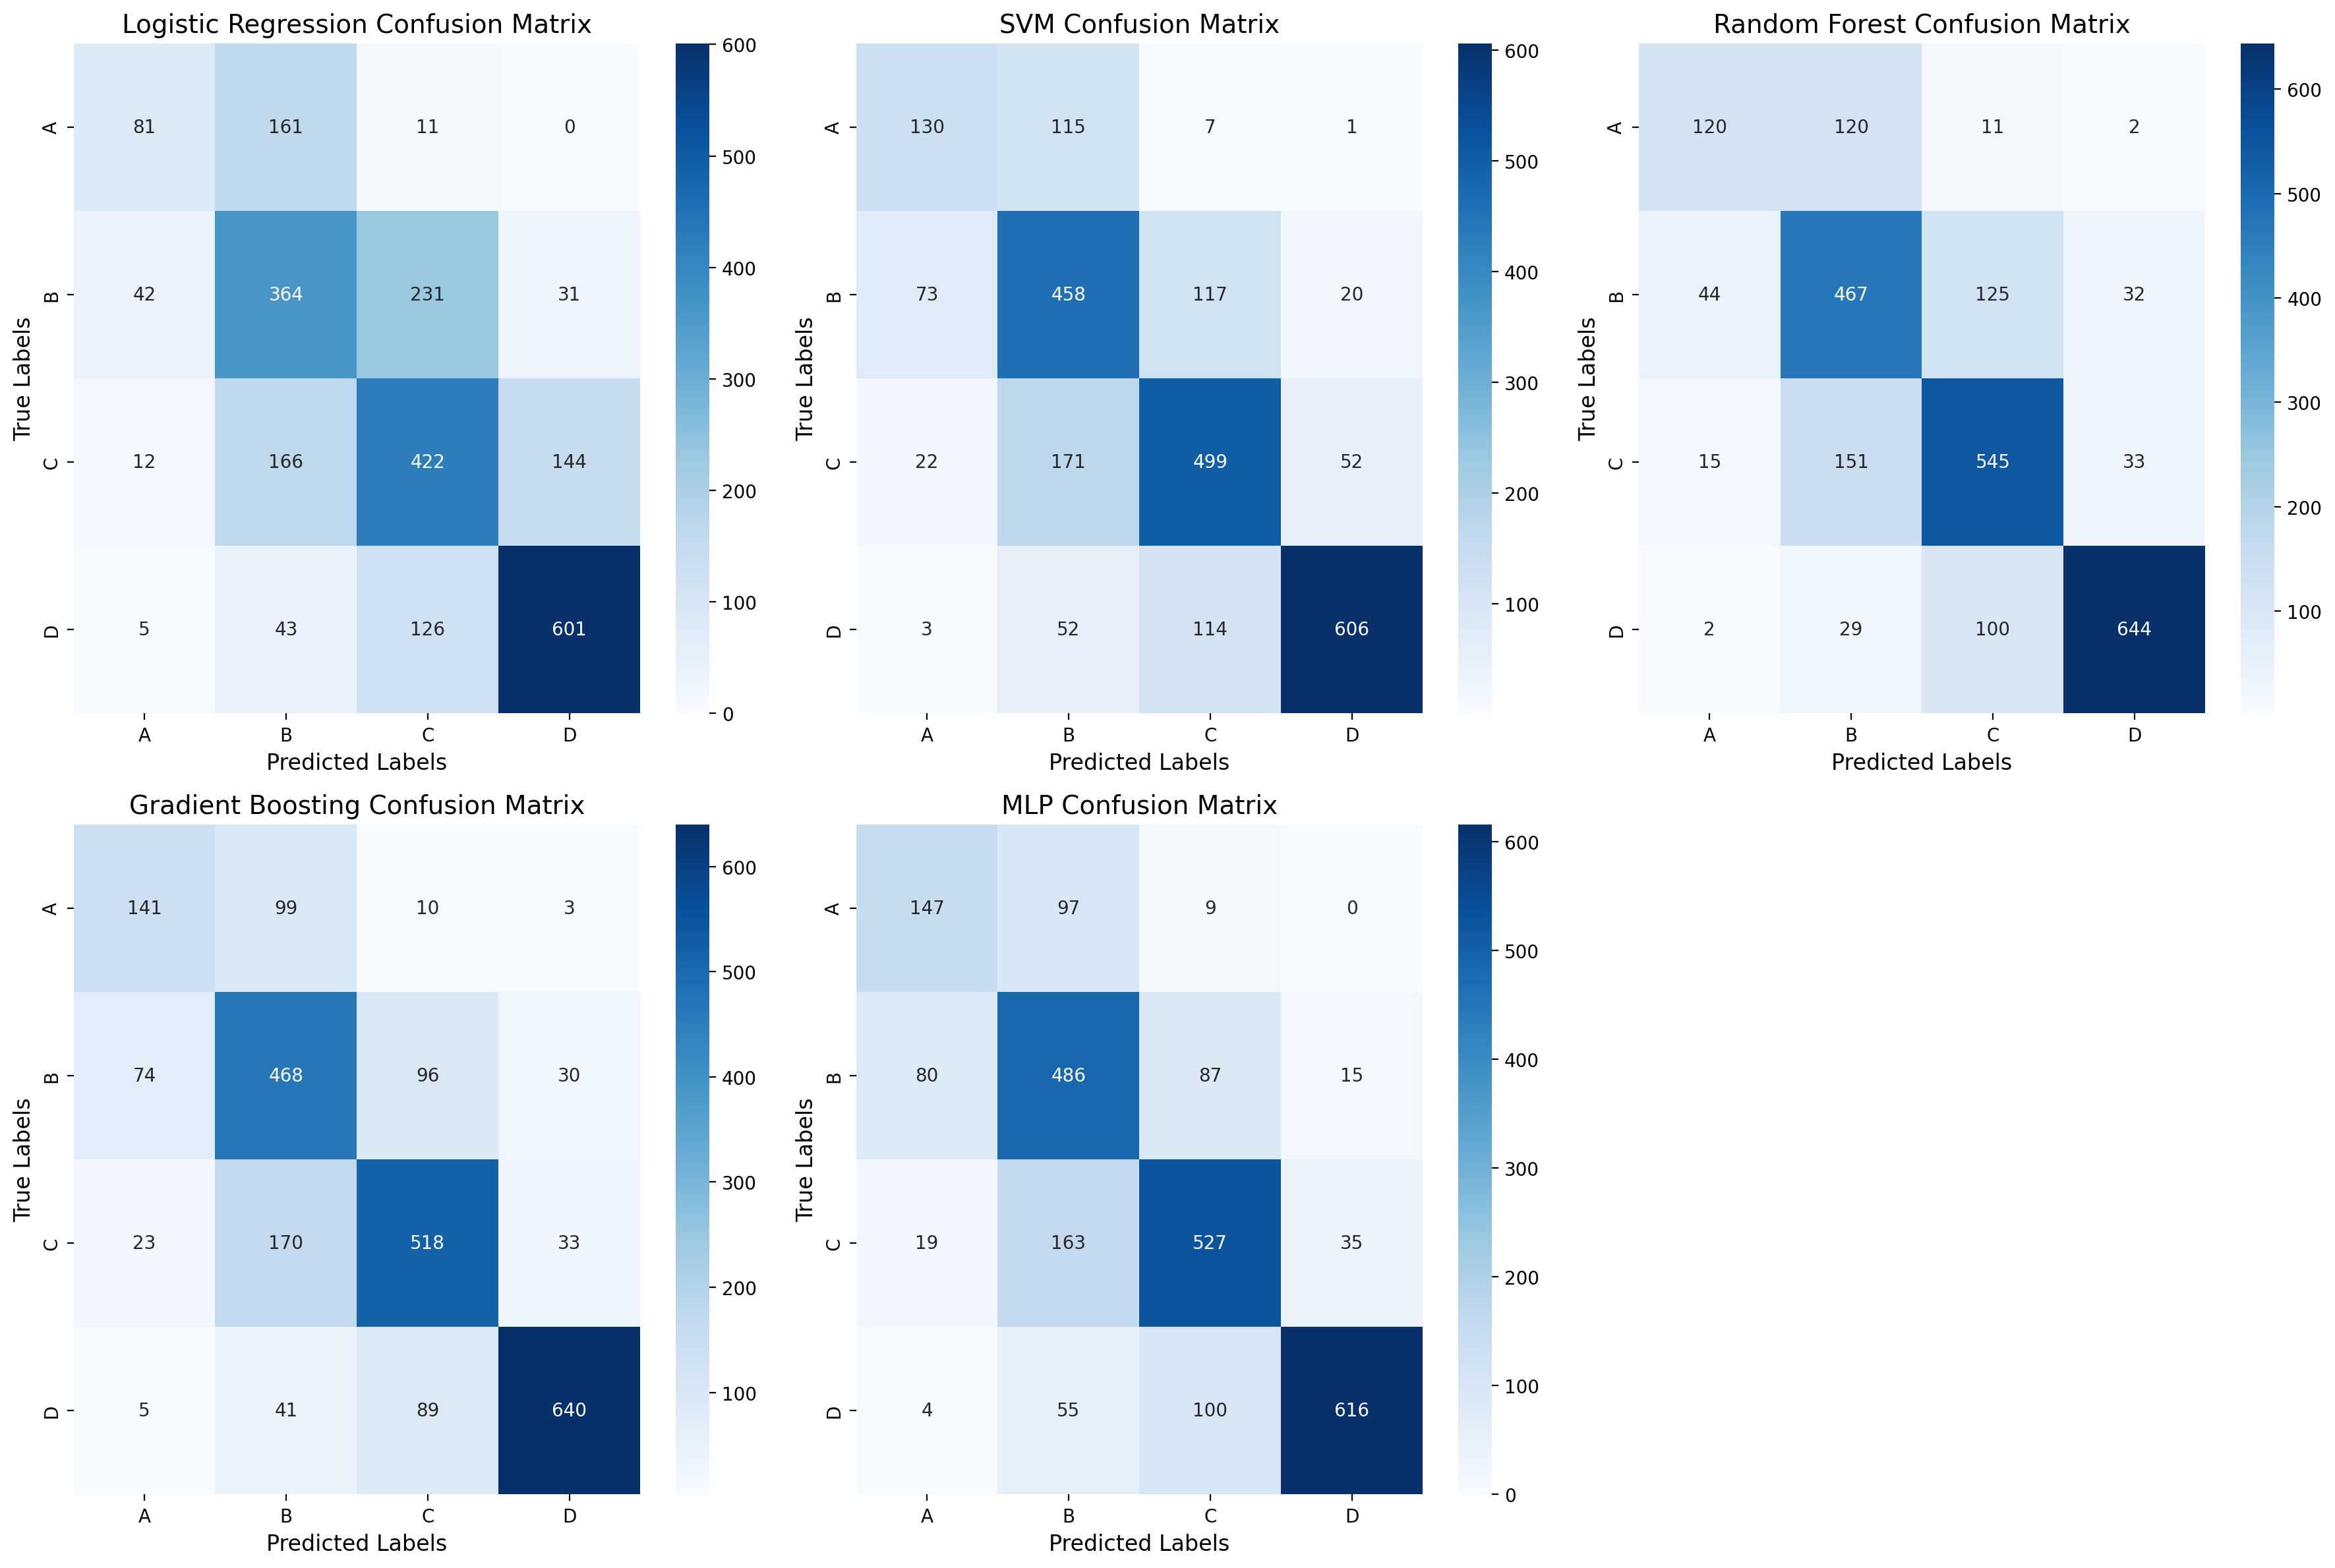

<Figure size 640x480 with 0 Axes>

In [22]:
# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=200)
axes = axes.flatten()  # Flatten to easily iterate over

# Plot the confusion matrices in each subplot
confusion_matrices = [
    (confusion_logreg, logreg_model.classes_, 'Logistic Regression'),
    (confusion_svm, svm_model.classes_, 'SVM'),
    (confusion_ranfor, ranfor_model.classes_, 'Random Forest'),
    (confusion_grad, grad_model.classes_, 'Gradient Boosting'),
    (confusion_mlp, mlp_model.classes_, 'MLP')
]

for i, (cm, classes, model_name) in enumerate(confusion_matrices):
    sb.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
               xticklabels=classes, yticklabels=classes, ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix', fontsize=14)
    axes[i].set_xlabel('Predicted Labels', fontsize=12)
    axes[i].set_ylabel('True Labels', fontsize=12)

# Remove any extra subplots if there are more than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display
plt.tight_layout()
plt.show()

plt.savefig("confusion_matrices.pdf", format='pdf') ###############

Final Prediction

In [23]:
df_test = pd.read_csv("data-performance-test-unlabelled.csv")

df_test['gender'] = df_test['gender'].map({'F': 0, 'M': 1}) 
df_test['BMI'] = df_test['weight_kg'] / ((df_test['height_cm']/100)** 2) 
df_test['BP_ratio'] = df_test['diastolic'] / df_test['systolic'] 
df_test.head(10)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,BMI,BP_ratio
0,36.0,1,177.5,73.1,13.8,82.0,135.0,50.8,19.1,64.0,252.0,23.201746,0.607407
1,35.0,1,176.4,77.7,21.2,74.0,129.0,34.0,11.7,41.0,213.0,24.970306,0.573643
2,34.0,0,162.6,52.1,20.4,72.0,115.0,31.3,28.2,65.0,208.0,19.705917,0.626087
3,32.0,0,156.3,60.8,38.9,68.0,120.0,25.2,5.3,13.0,90.0,24.887749,0.566667
4,27.0,1,165.4,65.0,24.5,82.0,123.0,36.5,10.2,46.0,179.0,23.759776,0.666667
5,24.0,0,162.6,58.9,26.0,74.0,131.0,26.4,14.7,31.0,172.0,22.277898,0.564885
6,64.0,1,168.0,73.0,20.5,84.0,127.0,41.8,12.6,27.0,190.0,25.864512,0.661417
7,25.0,0,158.1,56.3,29.6,60.0,105.0,21.9,6.1,19.0,141.0,22.523955,0.571429
8,22.0,1,179.1,74.7,13.2,71.0,121.0,40.9,21.2,62.0,259.0,23.287852,0.586777
9,37.0,1,175.0,63.7,17.1,76.0,113.0,40.7,9.1,41.0,220.0,20.800000,0.672566


In [24]:
X = df_test
print(ranfor_model.predict(X))

['A' 'C' 'A' 'D' 'C' 'C' 'B' 'D' 'B' 'C' 'D' 'C' 'D' 'B' 'B' 'D' 'B' 'C'
 'C' 'B']
